<a href="https://colab.research.google.com/github/SrAyush31/stock-market-prediction/blob/main/TimeSeriesForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction Using Time Series & LSTM on Zomato Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
zomato_df = pd.read_csv('/content/ZOMATO.NS.csv')

In [3]:
zomato_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-02,135.750000,140.750000,135.149994,139.699997,139.699997,66909732
1,2021-08-03,137.000000,140.800003,137.000000,139.399994,139.399994,46610001
2,2021-08-04,139.800003,141.000000,135.250000,138.399994,138.399994,41134419
3,2021-08-05,138.750000,138.899994,132.000000,134.949997,134.949997,38437134
4,2021-08-06,135.500000,136.199997,130.100006,131.350006,131.350006,31975356


In [4]:
zomato_df.Date=pd.to_datetime(zomato_df['Date'])

In [6]:
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       249 non-null    datetime64[ns]
 1   Open       249 non-null    float64       
 2   High       249 non-null    float64       
 3   Low        249 non-null    float64       
 4   Close      249 non-null    float64       
 5   Adj Close  249 non-null    float64       
 6   Volume     249 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.7 KB


In [7]:
zomato_df.Date.min(),zomato_df.Date.max()

(Timestamp('2021-08-02 00:00:00'), Timestamp('2022-07-29 00:00:00'))

In [8]:
zomato_df.Date.max()-zomato_df.Date.min()

Timedelta('361 days 00:00:00')

In [9]:
zomato_df.set_index('Date',inplace=True)

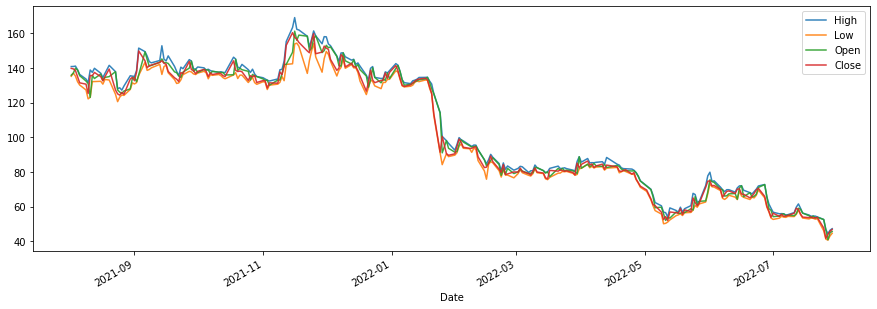

In [15]:
zomato_df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.9)

In [12]:
import plotly.express as px

# Evaluating Stationarity

In [13]:
px.histogram(zomato_df,x='High',nbins=50)

In [17]:
zomato_df.High.describe()

count    249.000000
mean     106.504819
std       35.363715
min       44.400002
25%       74.849998
50%       98.000000
75%      138.949997
max      169.000000
Name: High, dtype: float64

## We can't assume a uniform nor normal distribution in the plot above, because of that the statistical summary can helps us more, for this we will split the data into 10 chunks and compute mean and variance of each one.

In [18]:
np.round(zomato_df.shape[0]/10,0)

25.0

In [20]:
from statistics import stdev
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(zomato_df['High'].iloc[(i*25):(i*25)+25].mean())
    std.append(stdev(zomato_df['High'].iloc[(i*25):(i*25)+25]))

In [21]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)

,mean,std
0,136.958000,5.804177
1,141.517999,3.899356
2,143.029999,10.658321
3,147.838000,8.177079
4,127.625998,14.761112
5,88.300000,6.619180
6,83.594000,2.650288
7,68.658000,11.069258
8,70.339999,3.871262
9,55.131250,5.052416


## Above we see how both measures are clearly different in each chunk. However looking at the plot we could assume a constant variance as the ripple in the curve, but without a doubt trend is the most outstanding feature. Until now can assume it's a non-stationary series, but to know more about it we will evaluate two other methods.
## Seasonal decomposition is a function from statsmodels library which allows us to decompose the series into trend, seasonal and residual, either additive or multiplicative

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [25]:
decompose_result = seasonal_decompose(zomato_df.dropna(), freq=12) 

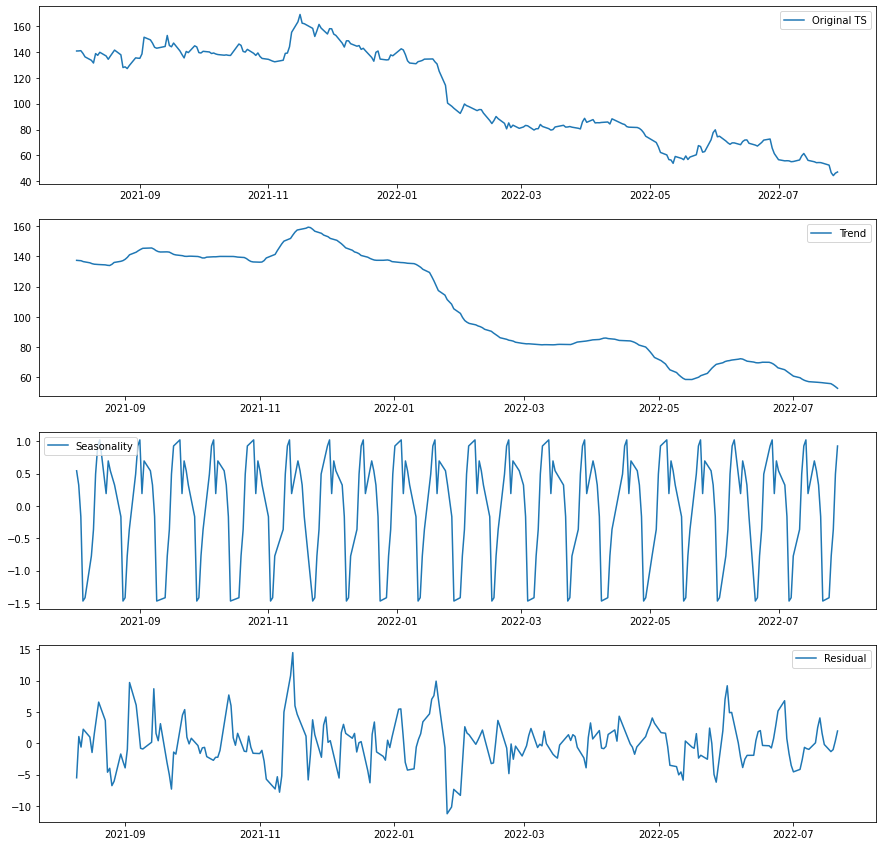

In [27]:
decompose_add=seasonal_decompose(zomato_df['High'], model='additive',freq=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(zomato_df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

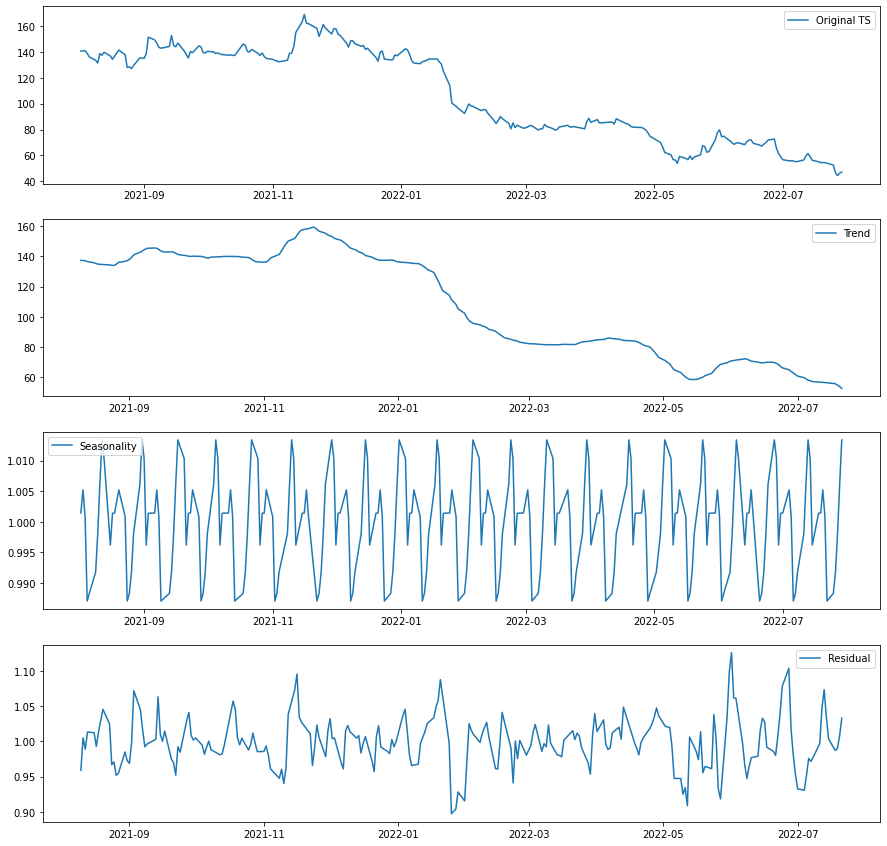

In [28]:
decompose_mul=seasonal_decompose(zomato_df['High'], model='multiplicative', freq=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(zomato_df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')

## Thoughts on Autocorrelation and Partial Autocorrelation
### Identification of an AR model is often best done with the PACF.
### For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

### Identification of an MA model is often best done with the ACF rather than the PACF.

### For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

###p,d,q p AR model lags d differencing q MA lags

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

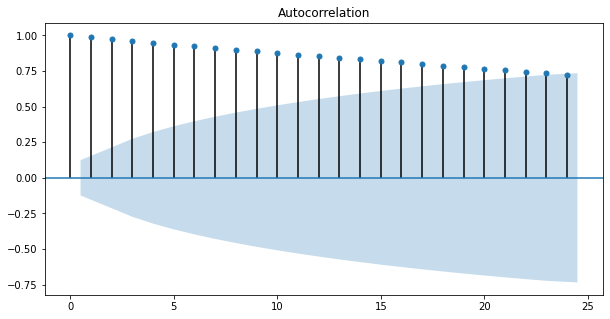

In [30]:
plt.rc("figure", figsize=(10,5))
plot_acf(zomato_df['High'])
print()

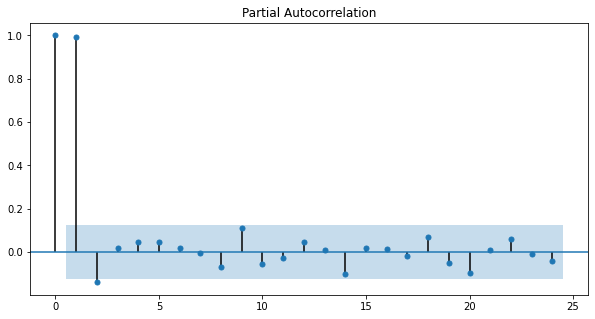

In [31]:
plt.rc("figure", figsize=(10,5))
plot_pacf(zomato_df['High'])
print()

## Finally, we will make the Augmented Dickey-Fuller test, using 5% as significance level and declaring the following hypothesis:

## H0= Serie corresponds to non-stationary type.
### H1= Serie corresponds to stationary type.

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
result = adfuller(zomato_df['High'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.265935
p-value: 0.930192
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


## As p-value is greater than 0.05 we fail to reject the null hypothesis, therefore there is not enough evidence to reject that we are working with a non-stationary series. Let's apply the log transformation to the serie and test again.

In [34]:
from numpy import log

result = adfuller(log(zomato_df['High']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.009849
p-value: 0.957710
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


### Based on every method applied we can endorse the serie clearly corresponds to a non-stationary type, which means that we have to convert this to stationary by using filters and complex transformations. However, deep learning approaches can lead us to build models which takes into account all of these characteristics and predict future values modestly, but as disadvantage it would take significantly more time to train such models.

In [35]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [36]:
model=ARIMA(zomato_df['High'],order=(1,1,1))
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [37]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.High   No. Observations:                  248
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -648.677
Method:                       css-mle   S.D. of innovations              3.309
Date:                Thu, 11 Aug 2022   AIC                           1305.353
Time:                        10:57:16   BIC                           1319.407
Sample:                             1   HQIC                          1311.011
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3768      0.252     -1.496      0.136      -0.870       0.117
ar.L1.D.High    -0.1275      0.214     -0.595      0.553      -0.548       0.293
ma.L1.D.High     0.3523      0.199      1.771      0.078      -0.038       0.742
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -7.8447           +0.0000j            7.8447            0.5000
MA.1           -2.8384           +0.0000j            2.8384            0.5000
-----------------------------------------------------------------------------
"""

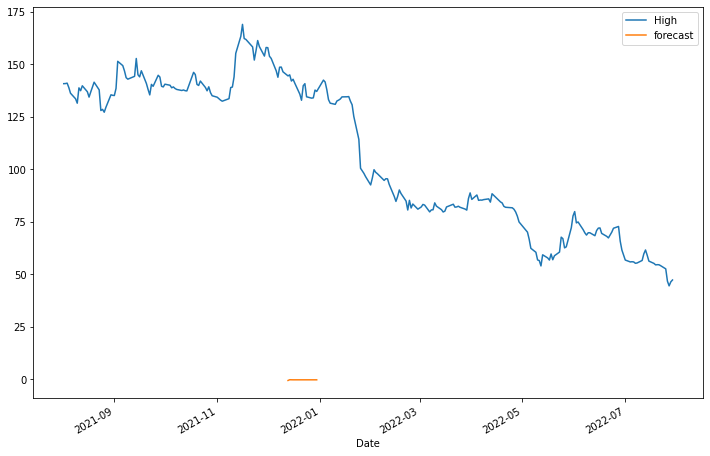

In [39]:
zomato_df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
zomato_df[['High','forecast']].plot(figsize=(12,8))

In [40]:
import statsmodels.api as sm

In [41]:
model=sm.tsa.statespace.SARIMAX(zomato_df['High'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



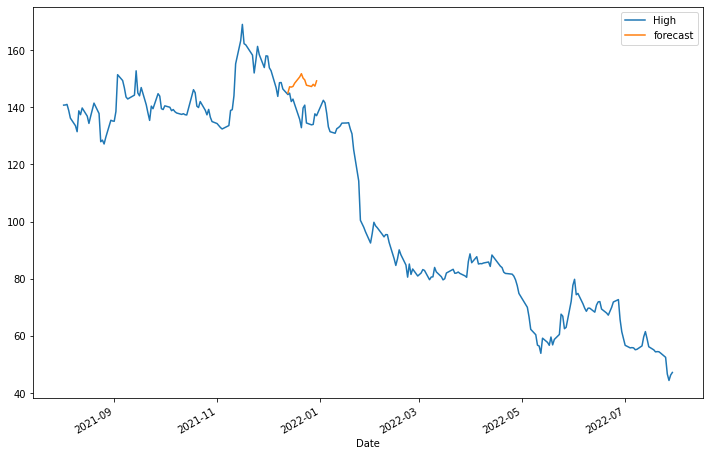

In [42]:
zomato_df['forecast']=results.predict(start=90,end=103,dynamic=True)
zomato_df[['High','forecast']].plot(figsize=(12,8))

In [43]:
from pandas.tseries.offsets import DateOffset
future_dates=[zomato_df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [45]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=zomato_df.columns)

In [46]:
future_datest_df.tail()

,Open,High,Low,Close,Adj Close,Volume,forecast
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
future_df=pd.concat([zomato_df,future_datest_df])

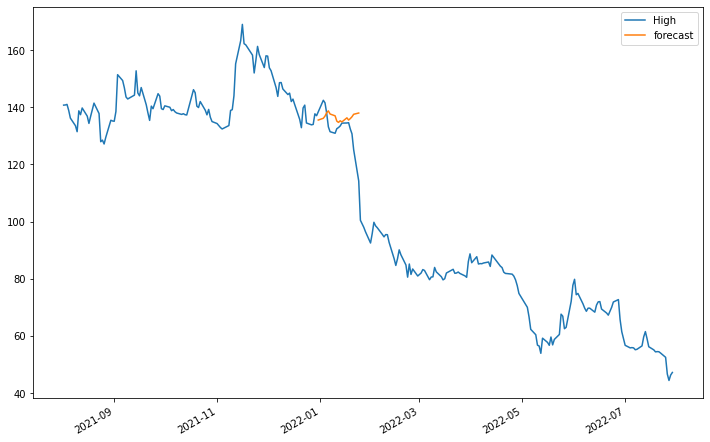

In [48]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['High', 'forecast']].plot(figsize=(12, 8)) 


## Prediction Using Deep Learning

In [70]:
zomato_df.tail()

,Open,High,Low,Close,Adj Close,Volume,forecast
Date,,,,,,,
2022-07-25,52.500000,52.500000,46.000000,47.599998,47.599998,232841112,NaN
2022-07-26,46.599998,46.650002,41.200001,41.650002,41.650002,412304737,NaN
2022-07-27,40.849998,44.400002,40.599998,43.950001,43.950001,411205172,NaN
2022-07-28,44.900002,46.299999,43.049999,45.700001,45.700001,267544569,NaN
2022-07-29,45.599998,47.200001,44.549999,46.799999,46.799999,177187972,NaN


### Firstly, we will define a new dataset equal to the existing one, but omitting the last four records, later we will use the model to predict such values.

In [49]:
new_df=zomato_df['High'].iloc[:-4]

In [71]:
import math
train_len = math.ceil(len(new_df)*0.65)
train_len

160

### Let's use 10 as a random window to be used in the model to build:

In [72]:
window=10

In [73]:
train_data = new_df[0:train_len]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [74]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

### Reshaping the training set to (number of records-window, number of time steps, 1)

In [75]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(150, 10, 1)

In [76]:
X_train

array([[[140.75    ],
        [140.800003],
        [141.      ],
        ...,
        [138.75    ],
        [137.399994],
        [139.75    ]],

       [[140.800003],
        [141.      ],
        [138.899994],
        ...,
        [137.399994],
        [139.75    ],
        [136.899994]],

       [[141.      ],
        [138.899994],
        [136.199997],
        ...,
        [139.75    ],
        [136.899994],
        [134.350006]],

       ...,

       [[ 82.900002],
        [ 79.650002],
        [ 80.599998],
        ...,
        [ 79.599998],
        [ 80.      ],
        [ 82.      ]],

       [[ 79.650002],
        [ 80.599998],
        [ 80.650002],
        ...,
        [ 80.      ],
        [ 82.      ],
        [ 83.300003]],

       [[ 80.599998],
        [ 80.650002],
        [ 83.949997],
        ...,
        [ 82.      ],
        [ 83.300003],
        [ 81.900002]]])

### this is relatively simple with one LSTM layer with relu activation function and one hidden fully connected layer, the optimizer used is Adam, number of epochs=10, batch_size=10 and loss function=Mean squared error:

In [77]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [78]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


### Creating the validation set using same logic as training:

In [79]:
test_data = new_df[train_len-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [80]:
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [81]:
X_val.shape, Y_val.shape

((85, 10, 1), (85,))

### Now that our validation set has the correct shape we can use it in the model to predict the next value.

In [82]:
prediction = model.predict(X_val)


In [83]:
len(prediction), len(Y_val)


(85, 85)

### As our prediction and actual values have the same shape we can use these sets to compute the error metrics, in this case we will use RMSE.

In [84]:
from sklearn.metrics import mean_squared_error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

Train rmse: 4.345161455194405
Validation rmse: 3.7817960200720564


### Below is a table which merged the actual and predicted values, therefore we can see for each record how differ these two and have an idea of how sidetracked we currently are.

In [85]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2022-03-24,82.349998,80.110153
2022-03-25,81.849998,80.636734
2022-03-28,81.000000,80.259422
2022-03-29,80.500000,79.542244
2022-03-30,86.000000,79.112679
...,...,...
2022-07-19,54.400002,54.089500
2022-07-20,54.500000,53.624111
2022-07-21,54.450001,53.474781


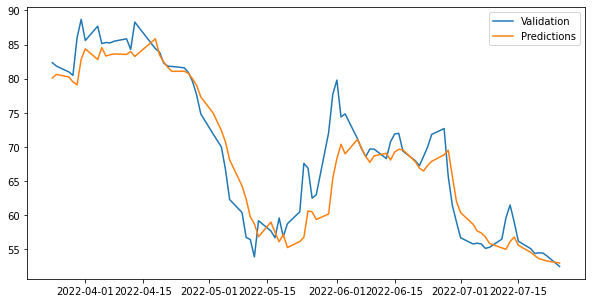

In [86]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

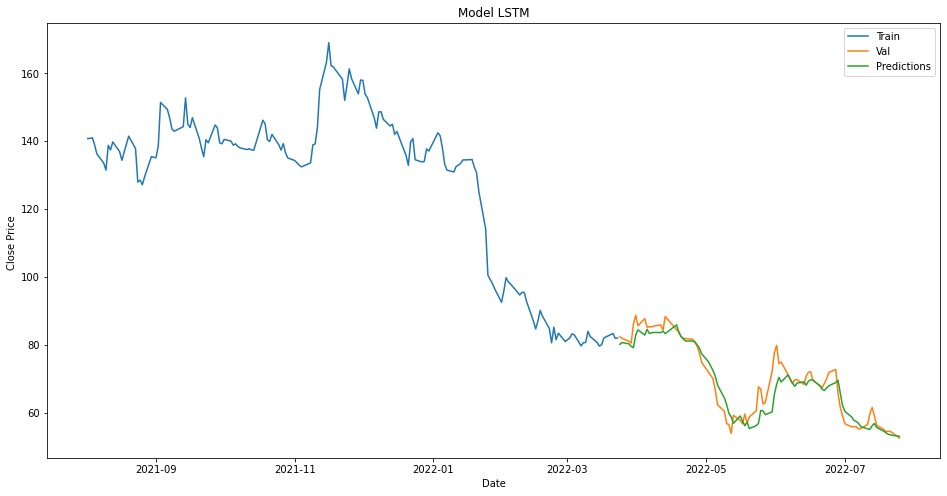

In [87]:
train = new_df[:train_len]
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price ')
plt.plot(train)
plt.plot(valid[['High','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()